In [1]:
import findspark
findspark.init()

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [3]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "graphframes:graphframes:0.8.2-spark3.2-s_2.12" --jars /opt/hive3/lib/hive-hcatalog-core-3.1.2.jar pyspark-shell'

In [4]:
from pyspark.sql import SparkSession

# Create a Spark session with increased memory settings and increase the memory
spark = SparkSession.builder \
    .appName("Big Data Project") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .enableHiveSupport() \
    .getOrCreate()


:: loading settings :: url = jar:file:/opt/spark3/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/osbdet/.ivy2/cache
The jars for the packages stored in: /home/osbdet/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-2f553e8b-618e-4a88-a340-d4f17295b63c;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 502ms :: artifacts dl 5ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------

In [5]:
df = spark.read.parquet("hdfs://localhost:9000/datalake/std/bikes_sharing")

In [6]:
df.show(5)

+----------+---+----------------+-------------+--------------------+----------------+--------------------+--------------+---------+---------+--------+---------+-------------+-------------------+-------------------+--------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----+---------+---------+-------+----------------+----------+----------+--------------+-----------+-------+-------------------+-------------------+---------+--------------+
|start_date|   |         ride_id|rideable_type|  start_station_name|start_station_id|    end_station_name|end_station_id|start_lat|start_lng| end_lat|  end_lng|member_casual|         started_at|           ended_at|duration|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike| dew|humidity|precip|precipprob|precipcover|snow|snowdepth|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|            sunrise|             sunset|moonphase|sunlight_hours|
+-----

In [8]:
df.count(), len(df.columns)

(12935463, 34)

In [6]:
from pyspark.sql.functions import col, to_timestamp

df = df.withColumn('sunrise', to_timestamp(col('sunrise'), 'yyyy-MM-dd HH:mm:ss'))
df = df.withColumn('sunset', to_timestamp(col('sunset'), 'yyyy-MM-dd HH:mm:ss'))
df = df.withColumn('started_at', to_timestamp(col('started_at'), 'yyyy-MM-dd HH:mm:ss'))
df = df.withColumn('ended_at', to_timestamp(col('ended_at'), 'yyyy-MM-dd HH:mm:ss'))


In [10]:

df.show(5)

+----------+----------------+-------------+----------------+--------------+-------------+-------------------+-------------------+--------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----+---------+---------+-------+----------------+----------+----------+--------------+-----------+-------+-------------------+-------------------+---------+--------------+
|start_date|         ride_id|rideable_type|start_station_id|end_station_id|member_casual|         started_at|           ended_at|duration|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike| dew|humidity|precip|precipprob|precipcover|snow|snowdepth|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|            sunrise|             sunset|moonphase|sunlight_hours|
+----------+----------------+-------------+----------------+--------------+-------------+-------------------+-------------------+--------+-------+-------+----+------------+----

In [13]:
df.printSchema()

root
 |-- start_date: date (nullable = true)
 |-- : integer (nullable = true)
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: float (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: float (nullable = true)
 |-- start_lat: float (nullable = true)
 |-- start_lng: float (nullable = true)
 |-- end_lat: float (nullable = true)
 |-- end_lng: float (nullable = true)
 |-- member_casual: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- duration: long (nullable = true)
 |-- tempmax: double (nullable = true)
 |-- tempmin: double (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslikemax: double (nullable = true)
 |-- feelslikemin: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-

In [7]:
from pyspark.sql.functions import dayofweek, hour

# Extract day of the week and hour of the day from the start time
df = df.withColumn('day_of_week', dayofweek(col('started_at')))
df = df.withColumn('hour_of_day', hour(col('started_at')))

In [10]:
from pyspark.sql.functions import hour

# Group by the hour of 'started_at' and count the number of rides
hourly_counts = df.groupBy(hour(col('started_at')).alias('hour')).count().orderBy('hour')

# Collect the data to the driver
hourly_counts_data = hourly_counts.collect()

# Convert to a Pandas DataFrame for plotting
import pandas as pd

hourly_counts_df = pd.DataFrame(hourly_counts_data, columns=['Hour', 'Ride Count'])
hourly_counts_df = hourly_counts_df.sort_values('Hour')  # Ensure it's sorted by hour just in case


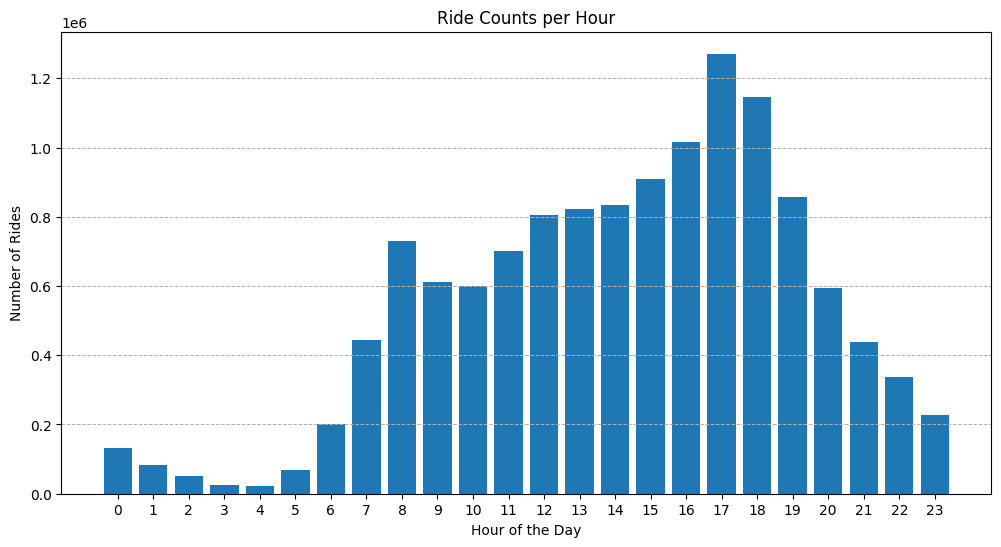

In [14]:
import matplotlib.pyplot as plt

# Plotting the number of rides per hour
plt.figure(figsize=(12, 6))
plt.bar(hourly_counts_df['Hour'], hourly_counts_df['Ride Count'])
plt.title('Ride Counts per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')
plt.xticks(range(24))  # Assuming hours are from 0 to 23
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()


In [8]:
from pyspark.sql.functions import when

# Define the time periods based on demand
df = df.withColumn(
    'time_of_day',
    when((hour(col('started_at')) >= 7) & (hour(col('started_at')) <= 9), 'Morning Commute')
    .when((hour(col('started_at')) >= 10) & (hour(col('started_at')) <= 15), 'Midday')
    .when((hour(col('started_at')) >= 16) & (hour(col('started_at')) <= 19), 'Evening Commute')
    .when((hour(col('started_at')) >= 20) & (hour(col('started_at')) <= 23), 'Night')
    .otherwise('Late Night')
)


In [9]:
import pyspark.sql.functions as F

In [10]:
# Create Vertices DataFrame (stations)
vertices = df.selectExpr("cast(start_station_id as string) as id").distinct()

In [11]:
# Edges DataFrame: Trips between stations with additional attributes
edges = df.select(
    F.col("start_station_id").cast("string").alias("src"),
    F.col("end_station_id").cast("string").alias("dst"),
    "duration",
    "temp",
    "humidity",
    "windspeed",
    "precip",
    "hour_of_day",
    "member_casual",
    "rideable_type",
    "start_station_name",
    "end_station_name",
    "start_lat",
    "start_lng",
    "end_lat",
    "end_lng"
)


In [26]:
""" !pip install graphframes """

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [12]:
from graphframes import GraphFrame

g = GraphFrame(vertices, edges)


In [13]:
# Calculate the in-degree and out-degree of each vertex (station)
inDegrees = g.inDegrees
outDegrees = g.outDegrees

## 1. Effect of Temperature on Ride Duration and Frequency

In [17]:
# Function to convert seconds to "0h 1m 50s" format
def format_duration(seconds):
    hours = F.floor(seconds / 3600)
    minutes = F.floor((seconds % 3600) / 60)
    seconds = F.round((seconds % 60), 2)
    return F.concat(
        hours, F.lit("h "),
        minutes, F.lit("m "),
        seconds, F.lit("s")
    )

# Group by different weather conditions and calculate average duration
agg_df = df.groupBy(
    F.when(F.col("temp") < 10, "<10°C")
    .when((F.col("temp") >= 10) & (F.col("temp") < 20), "10-19°C")
    .when((F.col("temp") >= 20) & (F.col("temp") < 30), "20-29°C")
    .otherwise(">=30°C").alias("Temperature_Range"),
    F.when(F.col("precip") == 0, "No Precipitation")
    .otherwise("Precipitation").alias("Precipitation_Status")
).agg(
    format_duration(F.avg("duration")).alias("Average_Duration"),
    F.count("ride_id").alias("Total_Trips")
)

# Sort and display the results
sorted_df = agg_df.orderBy("Temperature_Range", "Precipitation_Status")
sorted_df.show(truncate=False)


+-----------------+--------------------+----------------+-----------+
|Temperature_Range|Precipitation_Status|Average_Duration|Total_Trips|
+-----------------+--------------------+----------------+-----------+
|10-19°C          |No Precipitation    |0h 26m 10.35s   |2216134    |
|10-19°C          |Precipitation       |0h 25m 33.53s   |1033194    |
|20-29°C          |No Precipitation    |0h 26m 51.57s   |3045456    |
|20-29°C          |Precipitation       |0h 28m 55.19s   |2220498    |
|<10°C            |No Precipitation    |0h 8m 53.73s    |1219012    |
|<10°C            |Precipitation       |0h 17m 54.14s   |409516     |
|>=30°C           |No Precipitation    |0h 47m 10.11s   |65876      |
|>=30°C           |Precipitation       |0h 31m 52.78s   |5286       |
+-----------------+--------------------+----------------+-----------+



### Weather Impact:
Weather conditions significantly impact biking behavior. Mild and cooler temperatures with no precipitation are the most favorable conditions for biking.

### Adaptation to Precipitation
Riders adapt to precipitation differently based on temperature. In cooler temperatures, precipitation leads to shorter rides, while in mild temperatures, riders tend to continue with slightly longer rides even in the rain.

### Extreme Conditions
Very cold or hot conditions see a decrease in the number of trips, with the least being in extreme heat combined with rain.

# 2. Station Connectivity and Popularity Analysis

In [18]:
# Calculate PageRank
pagerank = g.pageRank(resetProbability=0.15, maxIter=10)

# Combine the results for analysis
station_stats = inDegrees.join(outDegrees, "id", how="outer") \
                         .join(pagerank.vertices, "id", how="outer") \
                         .withColumnRenamed("pagerank", "PageRank") \
                         .fillna(0)  # Fill null values with 0

# Show the results
station_stats.show()

+-------+--------+---------+-------------------+
|     id|inDegree|outDegree|           PageRank|
+-------+--------+---------+-------------------+
|30200.0|    9486|     7277| 0.5645342710878147|
|30201.0|    8301|     7473|  0.508834142255146|
|31000.0|    8178|     8144| 0.9832035896473297|
|31001.0|    2284|     2292|  0.408216904837503|
|31002.0|   14298|    13968| 1.5501602335661124|
|31003.0|   13826|    13288| 1.4308587239497053|
|31004.0|    5245|     5185| 0.7407007944999852|
|31005.0|   16203|    15805|  1.804951204862291|
|31006.0|   15681|    15158| 1.6721878561866939|
|31007.0|   14402|    14765| 1.6991898219802095|
|31009.0|    7390|     7427| 0.9563410332988835|
|31010.0|    9235|     9078| 1.3266651483052925|
|31011.0|   12247|    12134| 1.4403806908197097|
|31012.0|    3234|     3502|0.49023689697075246|
|31013.0|    8662|     8565| 1.0421803271542758|
|31014.0|   29706|    21604| 1.9256247114638365|
|31015.0|   11225|     8519|  0.881257964803279|
|31016.0|   11025|  

The analysis highlights the varying levels of station usage and their roles in the network. Stations with high degrees and PageRank scores are critical for the network's efficiency and should be prioritized for maintenance, bike availability, and infrastructure upgrades. Understanding these dynamics can assist in optimizing bike redistribution, enhancing customer experience, and planning for future station locations or expansions. Additionally, stations with a significant imbalance in inbound and outbound trips might require targeted interventions to ensure adequate bike availability.

# 3. Network Flow Analysis

In [14]:
# Calculate outgoing trips for each station
outgoing_trips = edges.groupBy("src").count().withColumnRenamed("src", "station_id").withColumnRenamed("count", "outgoing_trips")

# Calculate incoming trips for each station
incoming_trips = edges.groupBy("dst").count().withColumnRenamed("dst", "station_id").withColumnRenamed("count", "incoming_trips")

# Join the dataframes to get both incoming and outgoing trips for each station
net_flow = outgoing_trips.join(incoming_trips, "station_id", "outer").fillna(0)

# Calculate net flow
net_flow = net_flow.withColumn("net_flow", net_flow["incoming_trips"] - net_flow["outgoing_trips"])

# Order by net flow to see stations with the highest imbalance
net_flow_ordered = net_flow.orderBy(F.abs(F.col("net_flow")).desc())

# Display the results
net_flow_ordered.show()

+----------+--------------+--------------+--------+
|station_id|outgoing_trips|incoming_trips|net_flow|
+----------+--------------+--------------+--------+
|   31102.0|         41552|         28473|  -13079|
|   31215.0|         34818|         47624|   12806|
|   31296.0|         48114|         35495|  -12619|
|   31602.0|         38111|         26119|  -11992|
|   31124.0|         59352|         47374|  -11978|
|   31225.0|         29949|         41040|   11091|
|   31293.0|         21961|         32142|   10181|
|   31113.0|         35423|         25387|  -10036|
|   31131.0|         30673|         20723|   -9950|
|   31115.0|         29760|         19882|   -9878|
|   31117.0|         37573|         27782|   -9791|
|   31295.0|         37854|         46993|    9139|
|   31314.0|         30983|         39714|    8731|
|   31230.0|         40829|         49487|    8658|
|   31014.0|         21604|         29706|    8102|
|   31128.0|         54889|         62657|    7768|
|   31649.0|

### 1. Stations with High Negative Net Flow (More Bikes Leaving Than Arriving):
For instance, station 31102.0 exhibits a net flow of -13,079, indicating a significant number of bikes are being taken from this station but not returned in equal measure. This station seems to be a popular starting point for trips, possibly due to its location or other factors attracting riders. However, this pattern could lead to a shortage of bikes, necessitating regular replenishment to meet demand.

### 2. Stations with High Positive Net Flow (More Bikes Arriving Than Leaving):
On the other hand, station 31215.0 has a positive net flow of +12,806, suggesting that more bikes are being returned here than taken away. This station might be located at a key destination point, leading to an accumulation of bikes. Managing this overflow could involve redistributing bikes to other locations or considering expansion of parking facilities.

### 3. Implications for Bike Redistribution
The imbalance illustrated by the net flow at various stations points to a need for efficient bike redistribution. Stations with high negative net flow are prime candidates for bike restocking, while those with high positive net flow may require bikes to be transported to other, less-served stations.

### 4. Station Usage Patterns
The data suggests distinct patterns in how different stations are used within the network. Some stations primarily function as departure points, while others act as arrival points. Understanding and acknowledging these patterns is crucial for station capacity planning, establishment of new stations, and overall optimization of bike-sharing operations.

### 5. Strategic Planning:
For strategic planning, such as promotional activities or station upgrades, stations with high traffic (either incoming or outgoing) should be prioritized. These are critical nodes in your network and play a significant role in the overall user experience.

# 4. Route Preference and Efficiency:

In [20]:
# Using the edges DataFrame to analyze route preferences
popular_routes = edges.groupBy("src", "dst").agg(
    F.count("duration").alias("number_of_trips"),
    format_duration(F.avg("duration")).alias("Average_Duration")
).orderBy(F.desc("number_of_trips"))

# Displaying the top 10 most popular routes and their average durations
top_popular_routes = popular_routes.limit(10)
top_popular_routes.show()

+-------+-------+---------------+----------------+
|    src|    dst|number_of_trips|Average_Duration|
+-------+-------+---------------+----------------+
|31247.0|31247.0|          16777|   0h 53m 54.08s|
|31248.0|31248.0|          15656|   0h 58m 45.38s|
|31288.0|31288.0|          12684|   0h 54m 17.03s|
|31064.0|31064.0|          11904|    0h 52m 9.19s|
|31321.0|31321.0|          10603|   0h 58m 32.55s|
|31258.0|31258.0|          10576|   0h 37m 28.29s|
|31240.0|31240.0|           9860|     1h 6m 59.6s|
|31273.0|31273.0|           9064|   0h 51m 53.29s|
|31289.0|31289.0|           9053|   0h 47m 33.76s|
|31290.0|31290.0|           8184|   0h 47m 42.88s|
+-------+-------+---------------+----------------+



### 1. Circular Routes:
The most striking observation is that the top routes are circular (same start and end station). This indicates a high prevalence of users taking bikes for round trips, potentially for leisure or exercise.

### 2. Duration of Trips:
The average duration of these trips ranges from about 37 minutes to over an hour. This further supports the idea that these trips are likely for leisure or exercise purposes, as they are significantly longer than typical commuter trips.

### 3. Station Popularity:
The stations identified (e.g., 31247.0, 31248.0, 31288.0, etc.) are likely located in areas that are popular for leisure activities, such as parks, scenic areas, or recreational paths. These stations could be key areas for targeted marketing, additional bike allocations, or promotional activities.

### 4. Potential for New Services:
Given the popularity of these circular routes, there might be an opportunity to create guided tours, offer additional services like refreshments or rest areas, or even organize events that start and end at these stations.

### 5. Infrastructure Improvements: 
These stations might benefit from infrastructure improvements, like more bike racks, seating areas, or maintenance facilities, considering their high usage for longer trips.

# 5. Community Detection in the Network:

In [49]:
# Apply Label Propagation
result = g.labelPropagation(maxIter=5)

# Show results
result.select("id", "label").show()

+-------+-------------+
|     id|        label|
+-------+-------------+
|31910.0|1606317768705|
|31100.0| 996432412673|
|32426.0| 936302870530|
|31535.0| 996432412673|
|31666.0| 996432412673|
|32034.0| 867583393794|
|31041.0| 128849018880|
|32416.0|1529008357377|
|31006.0|1176821039104|
|32003.0|1675037245442|
|32204.0|1563368095745|
|31019.0|1022202216449|
|31225.0| 996432412673|
|32221.0| 309237645314|
|32089.0| 386547056642|
|31408.0| 996432412673|
|32259.0|1082331758595|
|32218.0|1297080123395|
|31126.0| 996432412673|
|31032.0| 635655159808|
+-------+-------------+
only showing top 20 rows



The results of the Label Propagation algorithm show different labels assigned to each station (represented by id). Stations with the same label value are considered part of the same community. These labels represent clusters or groups of stations that are frequently interconnected through bike trips.

### 1. Community Clusters: 
Stations with the same label form a community. This indicates that these stations are more frequently used together in the network, suggesting a pattern of trips within these clusters. For example, stations with the label 996432412673 form one community.

### 2. Regional Patterns: 
These communities may correspond to geographical or functional regions in the city. For instance, stations in a business district might form one community, while those in a residential area might form another.

### 3. Network Planning and Optimization:
Understanding these communities can aid in better planning and resource allocation. For example, if a particular community sees higher bike usage, additional bikes or maintenance resources can be allocated there.

### 4. Targeted Marketing and Services:
Knowledge of community clusters can help in crafting targeted marketing strategies or customizing services for different regions.

### 5. Infrastructure Development:
Insights from community detection can guide the development of new stations or expansion of existing ones to enhance connectivity within and between communities.

# 6. Rideable Type Popularity Analysis:

In [22]:
# Group by rideable_type, member_casual, and hour_of_day
popularity_df = edges.groupBy("rideable_type", "member_casual", "hour_of_day") \
                     .agg(
                         F.count(F.lit(1)).alias("total_trips"),
                         F.avg("duration").alias("average_duration")
                     ) \
                     .orderBy("rideable_type", "member_casual", "hour_of_day")

# Convert duration from seconds to a more readable format (hh:mm:ss)
popularity_df = popularity_df.withColumn("average_duration", 
                                         F.format_string("%02d:%02d:%02d", 
                                                         (F.col("average_duration") / 3600).cast("int"), 
                                                         ((F.col("average_duration") % 3600) / 60).cast("int"), 
                                                         (F.col("average_duration") % 60).cast("int")))

# Show the results
popularity_df.show(50)


+-------------+-------------+-----------+-----------+----------------+
|rideable_type|member_casual|hour_of_day|total_trips|average_duration|
+-------------+-------------+-----------+-----------+----------------+
| classic_bike|       casual|          0|      30514|        00:23:28|
| classic_bike|       casual|          1|      20702|        00:24:20|
| classic_bike|       casual|          2|      13660|        00:26:33|
| classic_bike|       casual|          3|       6778|        00:24:59|
| classic_bike|       casual|          4|       3970|        00:21:05|
| classic_bike|       casual|          5|       9468|        00:16:39|
| classic_bike|       casual|          6|      24904|        00:18:05|
| classic_bike|       casual|          7|      53061|        00:18:40|
| classic_bike|       casual|          8|     101403|        00:19:27|
| classic_bike|       casual|          9|     106156|        00:25:24|
| classic_bike|       casual|         10|     124553|        00:30:16|
| clas

### 1. Rideable Type Popularity:
* Electric Bikes: These might be popular among casual users for leisurely rides, especially during weekends or evenings. If the data shows a higher average duration for electric bikes, it could indicate their use for longer, more relaxed trips.
* Standard Bikes: Preferred by members, possibly for daily commutes. Shorter, more frequent trips during rush hours (morning and evening) could signify their use for work-related commuting.

### 2. Member vs. Casual Usage Patterns:
* Members: Likely to use bikes consistently at specific times (e.g., during rush hours for commuting). If the data shows a concentrated number of trips during these times, it suggests a strong reliance on the service for daily travel needs.
* Casual Users: Possibly show a varied pattern, with higher usage during weekends or non-peak hours. Longer trip durations might indicate leisure activities or tourism.

### 3. Hourly Variations:
* Peak usage times might differ between members (rush hours) and casual users (mid-day, evenings, weekends).
* Certain rideable types might be more popular during specific times of the day, reflecting their suitability for different activities (e.g., electric bikes for evening leisure rides).

### 4. Duration of Rides:
* Short-duration trips during peak hours could indicate efficient use for commuting, requiring a steady availability of bikes at key locations.
* Longer-duration trips during off-peak hours or weekends might require different operational strategies, like ensuring battery-charged bikes are available for casual users.

# 7. The Icing on the cake

In [17]:
from pyspark.sql.functions import col

# Extract distinct start stations
distinct_start_stations = edges.select(
    col("src").alias("station_id"),
    col("start_lat").alias("latitude"),
    col("start_lng").alias("longitude")
).distinct()

# Extract distinct end stations
distinct_end_stations = edges.select(
    col("dst").alias("station_id"),
    col("end_lat").alias("latitude"),
    col("end_lng").alias("longitude")
).distinct()

# Union the start and end stations and remove duplicates
distinct_stations = distinct_start_stations.union(distinct_end_stations).distinct()


In [24]:
# Collect the data to the driver node
stations_list = distinct_stations.collect()

In [25]:
!pip install folium

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for folium from https://files.pythonhosted.org/packages/a2/1a/37c7ee1bc806d6c32621fecc72c19f6a9f9b4369e5e8f406a7c16d49f031/folium-0.15.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for branca>=0.6.0 from https://files.pythonhosted.org/packages/2f/e7/603b136221de923055716d23e3047da71f92e0d8ba2c4517ce49a54fe768/branca-0.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.2 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 23.2 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [26]:
import folium

# Create a map
map = folium.Map(location=[38.9072, -77.0369], zoom_start=12)  # Adjust the location and zoom as needed

# Add station markers
for station in stations_list:
    folium.CircleMarker(
        location=[station['latitude'], station['longitude']],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(map)

# Save or display the map
map.save("bike_sharing_stations_map.html")


In [15]:
# Stations needing bikes (negative net flow)
stations_needing_bikes = net_flow.filter(net_flow['net_flow'] < 0)

# Stations with excess bikes (positive net flow)
stations_with_excess_bikes = net_flow.filter(net_flow['net_flow'] > 0)

In [18]:
from pyspark.sql.functions import udf
from math import radians, cos, sin, asin, sqrt

# Define the Haversine formula to calculate distance
def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    # Radius of earth in kilometers
    r = 6371
    return c * r

haversine_udf = udf(haversine)
# Join latitude and longitude for stations needing bikes and stations with excess bikes
# You may need to adjust this part based on how your DataFrame is structured
stations_needing_bikes = stations_needing_bikes.join(distinct_stations, "station_id")
stations_with_excess_bikes = stations_with_excess_bikes.join(distinct_stations, "station_id")

In [19]:
stations_needing_bikes.show()

+----------+--------------+--------------+--------+---------+----------+
|station_id|outgoing_trips|incoming_trips|net_flow| latitude| longitude|
+----------+--------------+--------------+--------+---------+----------+
|   32021.0|          2395|          1635|    -760|38.982494| -77.09202|
|   31117.0|         37573|         27782|   -9791|38.923336| -77.03505|
|   32046.0|          7930|          7917|     -13|38.965065| -77.10331|
|   31296.0|         48114|         35495|  -12619| 38.92415| -77.04065|
|   31069.0|          3821|          3590|    -231|38.871826| -77.10793|
|   31516.0|         12426|         12058|    -368|38.920673| -76.99584|
|   31029.0|          7017|          6320|    -697|38.896976| -77.08647|
|   31025.0|          6811|          6224|    -587| 38.88395|  -77.1078|
|   31310.0|         10224|          9244|    -980|38.955048| -77.07001|
|   31318.0|          6840|          6493|    -347|38.947075|  -77.0651|
|   32029.0|          3161|          2715|    -446|

In [20]:
stations_with_excess_bikes.show()

+----------+--------------+--------------+--------+---------+----------+
|station_id|outgoing_trips|incoming_trips|net_flow| latitude| longitude|
+----------+--------------+--------------+--------+---------+----------+
|   31412.0|          3582|          4003|     421|38.957462|-77.002235|
|   31076.0|          2669|          2983|     314| 38.83993| -77.08704|
|   31412.0|          3582|          4003|     421|38.957462| -77.00216|
|   31201.0|        102386|        105322|    2936|38.909878| -77.03438|
|   31255.0|         24009|         25378|    1369|38.906567| -77.05155|
|   31101.0|         80886|         83291|    2405| 38.91786|  -77.0319|
|   31611.0|         35391|         37217|    1826|38.900513| -76.98816|
|   31272.0|         36864|         39152|    2288| 38.88697| -77.01378|
|   31202.0|         70050|         73141|    3091|38.912956| -77.03172|
|   31293.0|         21961|         32142|   10181|38.902683|  -77.0612|
|   31600.0|         79257|         80838|    1581|

In [24]:
stations_needing_bikes = stations_needing_bikes.select("station_id", "net_flow", "latitude", "longitude").collect()
stations_with_excess_bikes = stations_with_excess_bikes.select("station_id", "net_flow", "latitude", "longitude").collect()

In [ ]:
def distance(station_i, station_j, station_coordinates):
    """
    Calculate the distance between two stations
    """
    lat1, lon1 = station_coordinates[station_i]
    lat2, lon2 = station_coordinates[station_j]
    return haversine(lat1, lon1, lat2, lon2)

In [ ]:
import pulp

# Create a new LP problem
prob = pulp.LpProblem("BikeRedistribution", pulp.LpMinimize)

# Create variables (x_ij for each pair of i, j)
x_vars = {}
for i in stations_with_excess_bikes:
    for j in stations_needing_bikes:
        x_vars[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", lowBound=0, cat='Integer')

# Objective Function
prob += pulp.lpSum([x_vars[(i, j)] * distance(i, j) for i in stations_with_excess_bikes for j in stations_needing_bikes])

# Constraints
# Supply constraint for each station with excess bikes
for i in stations_with_excess_bikes:
    prob += pulp.lpSum([x_vars[(i, j)] for j in stations_needing_bikes]) <= bike_surplus_at(i)

# Demand constraint for each station needing bikes
for j in stations_needing_bikes:
    prob += pulp.lpSum([x_vars[(i, j)] for i in stations_with_excess_bikes]) >= bike_deficit_at(j)

# Solve the problem
prob.solve()

# Print the optimal bike movements
for v in prob.variables():
    if v.varValue > 0:
        print(v.name, "=", v.varValue)


    x_32046_32021 = 10
    x_32046_31117 = 40
    x_31296_31117 = 30
    x_31516_31069 = 20
    x_31516_32021 = 20
